<img src="https://static.wixstatic.com/media/66c28f_db7a1ba3e35b4b17a6688472c889b7bf~mv2_d_2777_1254_s_2.png/v1/fill/w_710,h_320,al_c,q_85,usm_0.66_1.00_0.01/logo_yellow_white.webp" width=1000, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

***Some parts of the notebook are almost the exact copy of***  https://github.com/yandexdataschool/nlp_course

##  Attention

Attention layer can take in the previous hidden state of the decoder $s_{t-1}$, and all of the stacked forward and backward hidden states $H$ from the encoder. The layer will output an attention vector $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far $s_{t-1}$, and all of what we have encoded $H$, to produce a vector $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode $\hat{y}_{t+1}$. The decoder input word that has been embedded  $y_t$.

You can use any type of the attention scores between previous hidden state of the encoder $s_{t-1}$ and hidden state of the decoder $h \in H$, you prefer. We have met at least three of them:<br><br>

$$\operatorname{score}\left(\boldsymbol{h}, \boldsymbol{s}_{t-1}\right)=\left\{\begin{array}{ll}
\boldsymbol{h}^{\top} \boldsymbol{s}_{t-1} & \text { dot } \\
\boldsymbol{h}^{\top} \boldsymbol{W}_{\boldsymbol{a}} \boldsymbol{s}_{t-1} & \text { general } \\
\boldsymbol{v}_{a}^{\top} \tanh \left(\boldsymbol{W}_{\boldsymbol{a}}\left[\boldsymbol{h} ; \boldsymbol{s}_{t-1}\right]\right) & \text { concat }
\end{array}\right.$$
--------


**_We wil use "concat attention"_**:

First, we calculate the *energy* between the previous decoder hidden state $s_{t-1}$ and the encoder hidden states $H$. As our encoder hidden states $H$ are a sequence of $T$ tensors, and our previous decoder hidden state $s_{t-1}$ is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. $\Rightarrow$<br>
We have:<br>
$$H = \bigl[\boldsymbol{h}_{0}, ..., \boldsymbol{h}_{T-1}\bigr] \\ \bigl[\boldsymbol{s}_{t-1}, ..., \boldsymbol{s}_{t-1}\bigr]$$

The encoder hidden dim and the decoder hidden dim should be equal: **dec hid dim = enc hid dim**.<br>
 We then calculate the energy, $E_t$, between them by concatenating them together:<br>

$$\bigl[[\boldsymbol{h}_{0}, \boldsymbol{s}_{t-1}], ..., [\boldsymbol{h}_{T-1}, \boldsymbol{s}_{t-1}]\bigr]$$

And passing them through a linear layer (`attn` = $\boldsymbol{W}_{\boldsymbol{a}}$) and a $\tanh$ activation function:

$$E_t = \tanh(\text{attn}(H, s_{t-1}))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[enc hid dim, src sent len]** tensor for each example in the batch. We want this to be **[src sent len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, enc hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$


We can think of this as calculating a weighted sum of the "match" over all `enc_hid_dem` elements for each encoder hidden state, where the weights are learned (as we learn the parameters of $v$).

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

### Temperature SoftMax

<img src="https://miro.medium.com/max/793/1*S5X1pBq_jfDreJOs7yP-ZQ.png" height=100>

This gives us the attention over the source sentence!

Graphically, this looks something like below. $z = s_{t-1}$. The green/yellow blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.


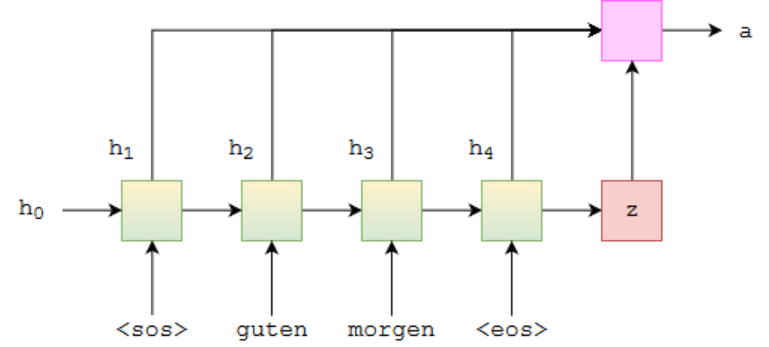

# Neural Machine Translation

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
! wget https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_ -O data.txt

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

--2022-11-23 11:27:50--  https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_
Resolving drive.google.com (drive.google.com)... 172.217.194.101, 172.217.194.138, 172.217.194.113, ...
Connecting to drive.google.com (drive.google.com)|172.217.194.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gk8nt9k2n45dnmcedkdl1m1nu0l2ud57/1669202850000/16549096980415837553/*/1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_?uuid=d99578bf-acff-4763-a95b-122d9b86b4d3 [following]
--2022-11-23 11:27:51--  https://doc-14-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gk8nt9k2n45dnmcedkdl1m1nu0l2ud57/1669202850000/16549096980415837553/*/1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_?uuid=d99578bf-acff-4763-a95b-122d9b86b4d3
Resolving doc-14-00-docs.googleusercontent.com (doc-14-00-docs.googleusercontent.com)... 74.125.24.132, 2404:6800:4003:c03::84
Connecting to doc

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

import torchtext
# from torchtext.legacy.data import Field, BucketIterator

import random
import math
import time
import numpy as np

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import tqdm

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

import gc

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
!nvidia-smi

Wed Nov 23 11:28:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We'll set the random seeds for deterministic results.

In [5]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

**UPD** Предлагаемый код для подготовки датасета на устаревшей версии Torchtext я не стала убирать для наглядности

## Preparing Data (legacy version of torchtext)

Here comes the preprocessing

In [ ]:
# tokenizer_W = WordPunctTokenizer()

# def tokenize_ru(x, tokenizer=tokenizer_W):
#     return tokenizer.tokenize(x.lower())[::-1]

# def tokenize_en(x, tokenizer=tokenizer_W):
#     return tokenizer.tokenize(x.lower())

In [ ]:
# SRC = Field(tokenize=tokenize_ru,
#             init_token = '<sos>', 
#             eos_token = '<eos>', 
#             lower = True)

# TRG = Field(tokenize=tokenize_en,
#             init_token = '<sos>', 
#             eos_token = '<eos>', 
#             lower = True)


# dataset = torchtext.legacy.data.TabularDataset(
#     path='data.txt',
#     format='tsv',
#     fields=[('trg', TRG), ('src', SRC)]
# )

In [ ]:
# print(len(dataset.examples))
# print(dataset.examples[0].src)
# print(dataset.examples[0].trg)

50000
['.', 'собора', 'троицкого', '-', 'свято', 'от', 'ходьбы', 'минутах', '3', 'в', ',', 'тбилиси', 'в', 'расположен', 'cordelia', 'отель']
['cordelia', 'hotel', 'is', 'situated', 'in', 'tbilisi', ',', 'a', '3', '-', 'minute', 'walk', 'away', 'from', 'saint', 'trinity', 'church', '.']


In [ ]:
# train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

# print(f"Number of training examples: {len(train_data.examples)}")
# print(f"Number of validation examples: {len(valid_data.examples)}")
# print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
# SRC.build_vocab(train_data, min_freq = 2)
# TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
# print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
# print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 14129
Unique tokens in target (en) vocabulary: 10104


And here is example from train dataset:

In [ ]:
# print(vars(train_data.examples[9]))

{'trg': ['other', 'facilities', 'offered', 'at', 'the', 'property', 'include', 'grocery', 'deliveries', ',', 'laundry', 'and', 'ironing', 'services', '.'], 'src': ['.', 'услуги', 'гладильные', 'и', 'прачечной', 'услуги', ',', 'продуктов', 'доставка', 'предлагается', 'также']}


When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, TorchText iterators handle this for us! 

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences. 

In [ ]:
# def _len_sort_key(x):
#     return len(x.src)

# BATCH_SIZE = 128

# train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
#     (train_data, valid_data, test_data), 
#     batch_size = BATCH_SIZE, 
#     device = device,
#     sort_key=_len_sort_key
# )

## Preparing data with torchtext=0.13.1

Код для предобработки данных требует понижения версии torchtext, что приводит к некоторым несовместимостям. Перепишем предобработку под свежую версию torchtext

Я пользовалась этой [инструкцией](https://pytorch.org/tutorials/beginner/translation_transformer.html?highlight=seq2seq)

In [6]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [7]:
# Считаем данные
def read_corpus(filename):
    data = []
    for line in open(filename, encoding='utf-8'):
        data.append(line.strip().split('\t'))
    return data

data = read_corpus('data.txt')

# разобьем их на train, val, test
l = len(data)
train_data, test_data, valid_data = torch.utils.data.random_split(data, 
                                                                  [int(l * 0.8), int(l * 0.15), l - int(l * 0.8) - int(l * 0.15)], 
                                                                  generator=torch.Generator().manual_seed(SEED)
                                                                  )

In [8]:
# Размер датасетов
len(train_data), len(valid_data), len(test_data)

(40000, 2500, 7500)

In [9]:
# Первый пример из train_data
next(iter(train_data))

['Located in Saint-Maurice, Le Paris-Vincennes is 50 metres from Bois de Vincennes and 8 km from the centre of Paris.',
 'Апартаменты Le Paris-Vincennes расположены в коммуне Сен-Морис в 50 метрах от Венсенского леса и в 8 км от центра Парижа.']

Получается, что source язык у нас с индексом 1, а target язык с индексом 0 (это понадобится для функции yield_tokens

In [10]:
# токенизатор будем использовать тот же, что предложен в ноутбуке
tokenizer_W = WordPunctTokenizer()

def tokenize_ru(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())[::-1]

def tokenize_en(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [11]:
# Сделаем словарь
SRC_LANGUAGE = 'ru'
TGT_LANGUAGE = 'en'

token_transform = {}
vocab_transform = {}

token_transform[SRC_LANGUAGE] = get_tokenizer(tokenize_ru)
token_transform[TGT_LANGUAGE] = get_tokenizer(tokenize_en)


# Вспомогательная функция для итерации по датасету
def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 1, TGT_LANGUAGE: 0} 

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])


# Определим вспомогательные индексы и их токены
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']


# Cделаем словари для текстов на русском и английском (на основе train_data)
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_data, ln),
                                                    min_freq=3,
                                                    specials=special_symbols,
                                                    special_first=True)


# Установим UNK_IDX в качестве дефолтного.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [12]:
vocab_transform[SRC_LANGUAGE].lookup_tokens(range(0, 200, 20))

['<unk>',
 'услугам',
 '«',
 'телевизор',
 'блюда',
 'все',
 'апартаментах',
 'комнатой',
 'всей',
 'оборудованная']

In [13]:
vocab_transform[TGT_LANGUAGE].lookup_tokens(range(0, 200, 20))

['<unk>',
 'away',
 'drive',
 'be',
 'has',
 'conditioned',
 'microwave',
 'fully',
 'living',
 'home']

In [14]:
len(vocab_transform[SRC_LANGUAGE]), len(vocab_transform[TGT_LANGUAGE])

(9172, 6676)

In [15]:
# Сделаем pipeline обработки текстов

# Функция осуществляющая трансформации 
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func


# Функция, которая добавляет к предложению bos и eos
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))
    

# Собираем pipeline обработки (Токенизация, замена слов на индексы в словаре, добавление bos и eos)
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# Функция для dataloader, которая преобразовывает предложения в тензоры
# Сначала предложение проходит pipeline обработки, 
# потом все предложения выравниваются по длине
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for tgt_sample, src_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [16]:
# Соберем dataloaders
BATCH_SIZE = 100

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [17]:
len(train_loader), len(val_loader), len(test_loader)

(400, 25, 75)

Проверим, что получили тот результат, который ожидаем

In [18]:
src, tgt = next(iter(train_loader))

In [19]:
src.shape, tgt.shape

(torch.Size([42, 100]), torch.Size([41, 100]))

In [20]:
" ".join(vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src[:, 50].numpy())))

'<bos> . кофе / чая для принадлежности и будильник , фен , freeview сети каналами и экраном плоским с телевизор , душ есть view <unk> » завтрак и постель « типа отеля номерах в <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

In [21]:
" ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt[:, 50].numpy())))

'<bos> guest rooms at <unk> view have en suite showers , a freeview flat - screen tv , hairdryer , alarm clock and tea and coffee facilities . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

## Let's use modules.py

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
!ls ./drive/MyDrive/DLS_NLP/5w_seq2seq/5w_hw_v3

'5w_[homework]NeuralMachineTranslation_AstafevaS_v3.ipynb'   __pycache__
 modules.py


In [24]:
%cd ./drive/MyDrive/DLS_NLP/5w_seq2seq/5w_hw_v3/

/content/drive/MyDrive/DLS_NLP/5w_seq2seq/5w_hw_v3


## Encoder

For a multi-layer RNN, the input sentence, $X$, goes into the first (bottom) layer of the RNN and hidden states, $H=\{h_1, h_2, ..., h_T\}$, output by this layer are used as inputs to the RNN in the layer above. Thus, representing each layer with a superscript, the hidden states in the first layer are given by:

$$h_t^1 = \text{EncoderRNN}^1(x_t, h_{t-1}^1)$$

The hidden states in the second layer are given by:

$$h_t^2 = \text{EncoderRNN}^2(h_t^1, h_{t-1}^2)$$

Extending our multi-layer equations to LSTMs, we get:

$$\begin{align*}
(h_t^1, c_t^1) &= \text{EncoderLSTM}^1(x_t, (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) &= \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}$$

<br><br>
<img src="https://drive.google.com/uc?id=1uIUxtZU8NvGdz0J9BlRSTbsBLFh32rxx">

In [ ]:
# you can paste code of encoder from modules.py
# the encoder can be like seminar encoder but you have to return outputs
# and if you use bidirectional you won't make the same operation like with hidden
# because outputs = [src sent len, batch size, hid dim * n directions]

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout, bidirectional):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(input_dim, emb_dim)        
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, bidirectional=bidirectional)        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src):
        
        #src = [src sent len, batch size]

        embedded = self.dropout(self.embedding(src))        
        #embedded = [src sent len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        if self.bidirectional:
            hidden = hidden.reshape(self.n_layers, 2, -1, self.hid_dim)
            hidden = hidden.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim)

            cell = cell.reshape(self.n_layers, 2, -1, self.hid_dim)
            cell = cell.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim)

        return outputs, hidden[-1, :, :], cell[-1, :, :]

## Attention

$$\operatorname{score}\left(\boldsymbol{h}, \boldsymbol{s}_{t-1}\right)=
\boldsymbol{v}_{a}^{\top} \tanh \left(\boldsymbol{W}_{\boldsymbol{a}}\left[\boldsymbol{h} ; \boldsymbol{s}_{t-1}\right]\right) \text { - concat attention}$$

In [ ]:
# you can paste code of attention from modules.py

def softmax(x, temperature=3): # use your temperature
    e_x = torch.exp(x / temperature)
    return e_x / torch.sum(e_x, dim=0)


class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim, bidirectional):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.bidirectional = bidirectional
        
        self.attn = nn.Linear((enc_hid_dim) * (1 + bidirectional) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1)
        
    def forward(self, hidden, encoder_outputs):
        
        # encoder_outputs = [src sent len, batch size, (enc_hid_dim) * (1 + bidirectional)]
        # hidden = [batch size, (enc_hid_dim) * (1 + bidirectional)]
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        # repeat hidden and concatenate it with encoder_outputs
        hidden = hidden.repeat(src_len, 1, 1)
        # encoder_outputs = encoder_outputs.permute(1, 0, 2)
        cat_hidden_out = torch.cat((hidden, encoder_outputs), dim = 2)
        
        # calculate energy
        energy = torch.tanh(self.attn(cat_hidden_out))
        #energy = [batch size, src len, dec hid dim]

        # get attention, use softmax function which is defined, can change temperature
        attention = self.v(energy)
        attention = softmax(attention)
            
        return attention

## Decoder with Attention

To make it really work you should also change the`Decoder` class from the classwork in order to make it to use `Attention`. 
You may just copy-paste `Decoder` class and add several lines of code to it.

The decoder contains the attention layer `attention`, which takes the previous hidden state $s_{t-1}$, all of the encoder hidden states $H$, and returns the attention vector $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The input word that has been embedded $y_t$, the weighted source vector $w_t$, and the previous decoder hidden state $s_{t-1}$, are then all passed into the decoder RNN, with $y_t$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}([y_t, w_t], s_{t-1})$$

We then pass $y_t$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(y_t, w_t, s_t)$$

The image below shows decoding the **first** word in an example translation.

The green/yellow blocks show the forward/backward encoder RNNs which output $H$, the red block is $z = s_{t-1} = s_0$, the blue block shows the decoder RNN which outputs $s_t = s_1$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

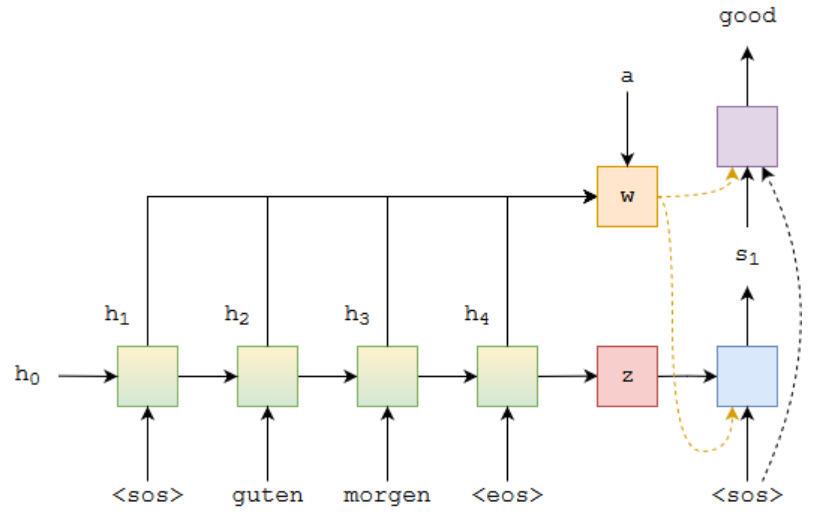

### Teacher forcing

Teacher forcing is a method for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input.

<img src="https://miro.medium.com/max/421/1*U3d8D_GnfW13Y3nDgvwJSw.png">

When training/testing our model, we always know how many words are in our target sentence, so we stop generating words once we hit that many. During inference (i.e. real world usage) it is common to keep generating words until the model outputs an `<eos>` token or after a certain amount of words have been generated.

Once we have our predicted target sentence, $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, we compare it against our actual target sentence, $Y = \{ y_1, y_2, ..., y_T \}$, to calculate our loss. We then use this loss to update all of the parameters in our model.



In [ ]:
# you can paste code of decoder from modules.py

class DecoderWithAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)        
        self.rnn = nn.GRU(dec_hid_dim + emb_dim, dec_hid_dim) # use GRU        
        self.out = nn.Linear(dec_hid_dim * 2 + emb_dim, output_dim) # linear layer to get next word        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        #input = [batch size]
        #hidden = [batch size, dec_hid_dim]
                
        input = input.unsqueeze(0) # because only one word, no words sequence         
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))        
        #embedded = [1, batch size, emb dim]
        
        # get weighted sum of encoder_outputs
        a = self.attention(hidden, encoder_outputs)
        #a = [batch size, src len, 1]
               
        # a * encoder_outputs = [src len, batch size, dec_hid_dim]
        weighted = torch.sum(a * encoder_outputs, dim=0, keepdim=True)
        #weighted = [1, batch size, dec_hid_dim]

        # concatenate weighted sum and embedded, break through the GRU
        cat_weighted = torch.cat((weighted, embedded), dim = 2)
        #cat_weighted = [1, batch size, dec_hid_dim + emb dim]
            
        output, hidden = self.rnn(cat_weighted, hidden.unsqueeze(0))
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        assert (output == hidden).all()

        # get predictions 
        prediction = self.out(torch.cat((embedded, weighted, hidden), dim = 2))
        #prediction = [1, batch size, output dim]
        
        return prediction, hidden.squeeze(0)

## Seq2Seq

Main idea:
* $w_t = a_t H$

* $s_t = \text{DecoderGRU}([y_t, w_t], s_{t-1})$

* $\hat{y}_{t+1} = f(y_t, w_t, s_t)$

**Note**: our decoder loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

Later on when we calculate the loss, we cut off the first element of each tensor to get:

$$\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

In [ ]:
# you can paste code of seq2seq from modules.py

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        if encoder.bidirectional:
            assert encoder.hid_dim * 2 == decoder.dec_hid_dim, \
                "Hidden dimensions of encoder and decoder must be equal!"
        else:
            assert encoder.hid_dim == decoder.dec_hid_dim, \
                    "Hidden dimensions of encoder and decoder must be equal!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        # src = [src sent len, batch size]
        # trg = [trg sent len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimention instead of zero
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        enc_states, hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        print('input', input.shape)
        
        for t in range(1, trg_len):

            output, hidden = self.decoder(input, hidden, enc_states)

            outputs[t] = output
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(-1).flatten()
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

## Training

In [44]:
# For reloading 
import modules
import imp
imp.reload(modules)

Encoder = modules.Encoder
Attention = modules.Attention
Decoder = modules.DecoderWithAttention
Seq2Seq = modules.Seq2Seq

In [45]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TGT_LANGUAGE])
ENC_EMB_DIM = 200
DEC_EMB_DIM = 200
HID_DIM = 400
N_LAYERS = 1 
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2
BIDIRECTIONAL = True

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, BIDIRECTIONAL)
attention = Attention(HID_DIM, HID_DIM * (1 + BIDIRECTIONAL), BIDIRECTIONAL)
dec = Decoder(OUTPUT_DIM, ENC_EMB_DIM, HID_DIM, HID_DIM * (1 + BIDIRECTIONAL), DEC_DROPOUT, attention)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [46]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9172, 200)
    (rnn): LSTM(200, 400, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): DecoderWithAttention(
    (attention): Attention(
      (attn): Linear(in_features=1600, out_features=800, bias=True)
      (v): Linear(in_features=800, out_features=1, bias=True)
    )
    (embedding): Embedding(6676, 200)
    (rnn): GRU(1000, 800)
    (out): Linear(in_features=1800, out_features=6676, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [47]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,725,877 trainable parameters


Целью задания является получить как можно более высокий $BLEU$ на тестовом датасете (подробнее об этой метрике рассказано ниже в ноутбуке). Поэтому, перепишем функции для обучения таким образом, чтобы считать $BLEU$ на каждой эпохе

In [48]:
from torchtext.data.metrics import bleu_score
from tqdm.autonotebook import tqdm

def cut_on_eos(tokens_iter):
    for token in tokens_iter:
        if token == '<eos>':
            break
        yield token

def remove_tech_tokens(tokens_iter, tokens_to_remove=['<bos>', '<unk>', '<pad>']):
    return [x for x in tokens_iter if x not in tokens_to_remove]

def get_text(x, vocab_transform):
     generated = remove_tech_tokens(cut_on_eos(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(x))))
     return generated

In [49]:
PAD_IDX = vocab_transform[TGT_LANGUAGE].lookup_indices(['<pad>'])[0]
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, epoch, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, val_bleu_hist=None):
    model.train()    
    epoch_loss = 0
    history = []

    pbar = tqdm(enumerate(iterator), total=len(iterator), leave=False)
    pbar.set_description(f"Epoch {epoch}. Training")
    for i, batch in pbar:   
        src = batch[0].to(device)
        trg = batch[1].to(device)
        
        optimizer.zero_grad()
        
        output = model(src, trg, 0.4)        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, OUTPUT_DIM)
        trg = trg[1:].view(-1)        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)        
        optimizer.step()
        
        epoch_loss += loss.item()        
        history.append(loss.cpu().data.numpy())

        del src, trg, output, batch, loss
        gc.collect()
        torch.cuda.empty_cache()

        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
                ax[1].set_title('Train valid loss history')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            if val_bleu_hist is not None:
                ax[2].plot(val_bleu_hist, label='valid bleu')
                ax[2].set_xlabel('Epoch')
                ax[2].set_title(f'Valid bleu history.')            
            plt.legend()            
            plt.show()            
    return epoch_loss / len(iterator)

def evaluate(model, epoch, iterator, criterion):    
    model.eval()    
    epoch_loss = 0 
    original_tokens = [] 
    generated_tokens = [] 
    
    with torch.no_grad():
        pbar = tqdm(enumerate(iterator), total=len(iterator), leave=False)
        pbar.set_description(f"Epoch {epoch}. Validation")
        for i, batch in pbar:
            src = batch[0].to(device)
            trg = batch[1].to(device)
            output = model(src, trg, 0) #turn off teacher forcing
            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output_loss = output[1:].view(-1, OUTPUT_DIM)
            trg_loss = trg[1:].view(-1)
            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output_loss, trg_loss)            
            epoch_loss += loss.item()

            #bleu
            output = output[1:].argmax(-1)          
            original_tokens.extend([x for x in trg.cpu().numpy().T]) 
            generated_tokens.extend([x for x in output.detach().cpu().numpy().T]) 
            
            del src, trg, trg_loss, output, output_loss, batch, loss
            gc.collect()
            torch.cuda.empty_cache() 

        original_text = [[get_text(x, vocab_transform)] for x in original_tokens]
        generated_text = [get_text(x, vocab_transform) for x in generated_tokens] 
        val_bleu = bleu_score(generated_text, original_text)
    return epoch_loss / len(iterator), val_bleu

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

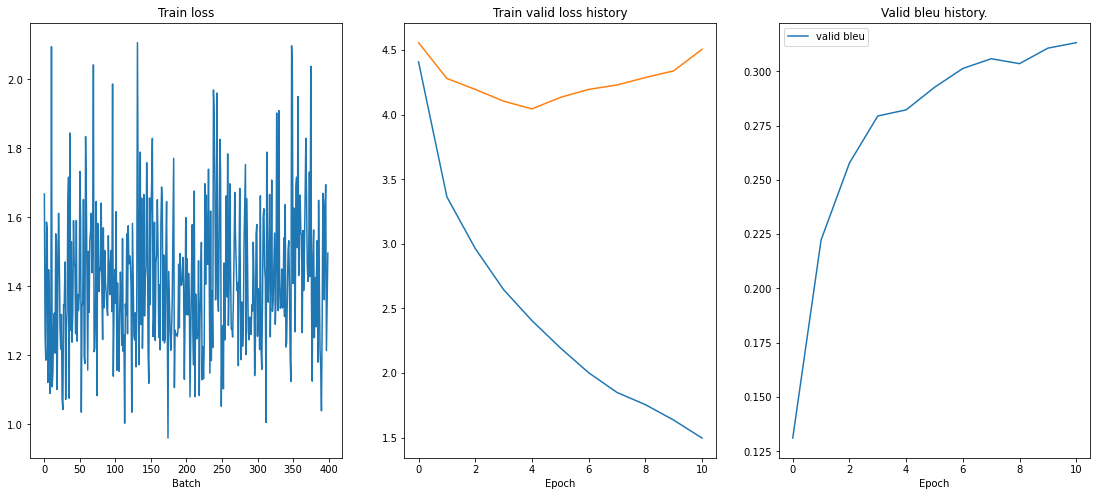

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 12 | Time: 7m 16s
	Train Loss: 1.420 | Train PPL:   4.138
	 Val. Loss: 4.630 |  Val. PPL: 102.491
	 Val. bleu: 0.311


In [52]:
train_history = []
valid_history = []
val_bleu_hist = []
N_EPOCHS = 12
CLIP = 5
best_bleu = 0

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, epoch, train_loader, optimizer, criterion, CLIP, train_history, valid_history, val_bleu_hist)
    valid_loss, val_bleu = evaluate(model, epoch, val_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if val_bleu > best_bleu:
        best_bleu = val_bleu
        torch.save(model.state_dict(), 'best-val-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    val_bleu_hist.append(val_bleu)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f'\t Val. bleu: {val_bleu:.3f}')
    gc.collect()
    torch.cuda.empty_cache()

torch.save(model.state_dict(), 'last-model.pt')

__Let's take a look at our network quality__:

In [55]:
def generate_translation(src, trg, model, vocab_transform):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output[1:].argmax(-1)

    original = remove_tech_tokens(cut_on_eos(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(trg[:,0].cpu().numpy()))))
    generated = remove_tech_tokens(cut_on_eos(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(output[:, 0].cpu().numpy()))))
    
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

In [56]:
model.load_state_dict(torch.load('best-val-model.pt'))
batch = next(iter(test_loader))

for idx in range(10):
    src = batch[0][:, idx:idx+1].to(device)
    trg = batch[1][:, idx:idx+1].to(device)
    generate_translation(src, trg, model, vocab_transform)

Original: an on - site restaurant is available and serves breakfast , lunch , and dinner .
Generated: the on - site restaurant is breakfast , serves breakfast , lunch and dinner .

Original: the apartment features parquet floors and a minimalist décor . it is composed of a separate bedroom , a living room , a bathroom , and a fully equipped kitchen .
Generated: with parquet floors , this apartment comes with a separate bedrooms , a bedrooms , a , , a bathroom , and a fully equipped kitchen .

Original: the bathroom comes with a shower and toilet .
Generated: the bathroom comes with a shower and toilet toilet .

Original: a massage service is available .
Generated: massage can be booked on site .

Original: guests can enjoy a lake and city view .
Generated: you can enjoy lake and city views from the room .

Original: guests can also enjoy barbecuing outside where wooden gazebos are provided or relax with a drink at the bar .
Generated: guests can also enjoy the barbecue in the one of th

## Bleu

[link](https://www.aclweb.org/anthology/P02-1040.pdf)

<img src="https://drive.google.com/uc?id=1umJF2S8PiayxD9Xo8xvjW8QsrSLidozD" height=400>

In [57]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [58]:
import tqdm
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_loader)):
        src = batch[0].to(device)
        trg = batch[1].to(device)

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:].argmax(-1)        
        original_text.extend([get_text(x, vocab_transform) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, vocab_transform) for x in output.detach().cpu().numpy().T])

75it [00:24,  3.04it/s]


In [59]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

31.288394226052514

## Recommendations:
* use bidirectional RNN
* change learning rate from epoch to epoch
* when classifying the word don't forget about embedding and summa of encoders state 
* you can use more than one layer

## You will get:

* `2` points if `21 < bleu score < 23`
* `4` points if `23 < bleu score < 25`
* `7` points if `25 < bleu score < 27`
* `9` points if `27 < bleu score < 29`
* `10` points if `bleu score > 29`

When your result is checked, your 10 translations will be checked too


## Your Conclusion
* information about your the results obtained 
* difference between seminar and homework model

In [2]:
import torchtext
import torch
torchtext.__version__, torch.__version__

('0.13.1', '1.12.1+cu113')

* bleu score на тестовой выборке = 31.29 %
* В Энкрдере использована LSTM, 1 слой и bidirectional = True, в декодере - однослойная GRU 
* Из Энкодера забирались только последние 2 слоя hidden (прямой и обратный проход). 
* Softmax с температурой = 3
* teacher forcing применялся с вероятностью 0.4
* Модель seq2seq имеет $22,725,877$ параметров 
* Потребовалось немало усилий, чтобы "победить" ограничения в памяти Colab:
  - уменьшен размер батча до 100
  - уменьшен размер словаря (min_freq=3)
  - добавлены несколько промежуточных очисток памяти
* Подготовка данных была проведена на текущей версии torchtext (0.13.1) на основе туториала из pytorh. [Тут ссылка](https://pytorch.org/tutorials/beginner/translation_transformer.html?highlight=seq2seq). Для наглядности я оставила код для преобработки данных на старой версии torchtext.
* Реализация модели seq2seq была выполнена с помощью семинарского ноутбука и [этой статьи](https://habr.com/ru/post/567794/)
*  В сравнении с семинарским решением применение Attention значительно увеличило качество модели (в семинарском ноутбуке bleu = 20.89)
* В процессе работы было выполнено несколько версий реализаций модели seq2seq. Данная версия показала лучшее качество.
* Увеличение размера эмбеддингов и добавление еще одного слоя в LSTM значительно увеличивают количество параметров модели и время обучения, но, похоже, не увеличивают bleu score.
* Выяснилось, что bleu score не коррелирует с loss. Это видно по графикам. На центральном графике оранжевая линия - это график loss на валидации. Начиная с 4 эпохи, loss повышается, однако bleu score на валидации (правый график) продолжает расти.
* Думаю, что при наличии большего времени и ресурсов GPU можно было бы улучшить качество.